## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-03 21:27:57--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178.21K  --.-KB/s    in 0.1s    

2021-10-03 21:27:58 (1.33 MB/s) - ‘CreditScoring.csv’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [23]:
categorical_var = list(df.dtypes[df.dtypes == 'object'].index)
numerical_var = list(df.dtypes[df.dtypes != 'object'].index)
print(categorical_var)
print(numerical_var)

['home', 'marital', 'records', 'job']
['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default']


In [25]:
del numerical_var[-1]
numerical_var

['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price']

In [10]:
from sklearn.model_selection import train_test_split

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [17]:
full_train, X_test, full_train_y, y_test = train_test_split(df, df.default.values, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(full_train, full_train_y, test_size=0.25, random_state=1)

In [18]:
X_train.shape, X_val.shape, X_test.shape

((2672, 14), (891, 14), (891, 14))

In [19]:
del X_train['default']
del X_test['default']
del X_val['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [14]:
from sklearn.metrics import auc, roc_curve

In [26]:
for col in numerical_var:
    fpr, tpr, _= roc_curve(y_train, X_train[col].values)
    score = auc(fpr, tpr)
    
    if score < 0.5:
        fpr, tpr, _= roc_curve(y_train, - X_train[col].values)
        score = auc(fpr, tpr)
    
    print(f"AUC score for {col} =  {score}")

AUC score for seniority =  0.7093778624491943
AUC score for time =  0.5608662489595051
AUC score for age =  0.5732933272499939
AUC score for expenses =  0.5009184217217011
AUC score for income =  0.682006666132633
AUC score for assets =  0.6486042567122802
AUC score for debt =  0.5047829675783548
AUC score for amount =  0.5910773431595518
AUC score for price =  0.5043329862114843


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [27]:
from sklearn.feature_extraction import DictVectorizer

In [28]:
cols = ['seniority', 'income', 'assets', 'records', 'job', 'home']
dv = DictVectorizer(sparse=False)

In [29]:
train_dicts = X_train[cols].to_dict(orient='records')
test_dicts = X_test[cols].to_dict(orient='records')
val_dicts = X_val[cols].to_dict(orient='records')

In [30]:
train = dv.fit_transform(train_dicts)
test = dv.transform(test_dicts)
val = dv.transform(val_dicts)

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
logReg = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
logReg.fit(train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [36]:
probas = logReg.predict_proba(val)[:, 1]

In [37]:
from sklearn.metrics import roc_auc_score

In [40]:
roc_auc = roc_auc_score(y_val, probas)
print(f"AUC is : {round(roc_auc, 3)}")

AUC is : 0.812


## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [43]:
np.linspace(0, 1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [47]:
auc_scores = []

for threshold in np.linspace(0, 1, 101):
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (probas >= threshold)
    predict_negative = (probas< threshold)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    auc_scores.append((tp, fp, fn, tn, precision, recall))

<ipython-input-47-cc63582de770>:16: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


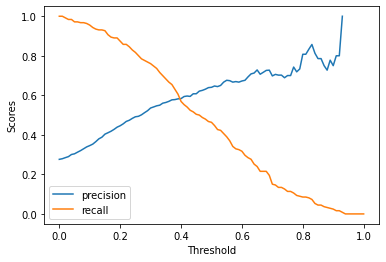

In [48]:
scores = pd.DataFrame(auc_scores, columns = ['tp', 'fp', 'fn', 'tn', 'precision', 'recall'])
threshold = np.linspace(0, 1, 101)

plt.plot(threshold, scores.precision, label='precision')
plt.plot(threshold, scores.recall, label='recall')
plt.legend()

plt.xlabel('Threshold')
plt.ylabel('Scores')
plt.show()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.